<h1 align="center"><font face="Times New Roman">Poisson Regression with Neural Network</font> </h1>

<font face="Times New Roman">
<h2>1. Load the Libraries</h2>
<p>&#10060; TensorFlow package must be installed before loading the libraries. This code must be running in the environment in which TensorFlow is installed </p>
Load the libraries for the execusion of the program. Incase of an error, use the below installation procedure</font>
<pre><code>
    # Install a pip package in the current Jupyter kernel
    import sys
    !{sys.executable} -m pip install *package_name*
</code></pre>

In [1]:
### Load the libraries
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.metrics import confusion_matrix

<font face="Times New Roman"><h2>2. Import Data</h2>
Set the path variable to where the github code folder is cloned to access the data</font>

In [2]:
## Importing Dataset
path = 'C:/Users/DELL/OneDrive/Documents/project/Updated Code and Datasets/'
df = pd.read_csv(path + 'model_data.csv')

<font face="Times New Roman"><h2>3. Data Cleaning and pre-processing</h2></font>
<font face="Times New Roman"><h3>3.1 Obtaining Required Variables</h3></font>

In [3]:
# Considering Data Only from Games >= 7
# Using Past 6 Games for Information
data = df.dropna(subset=['RefGSF'])

## Filter Dataset with Required Variables Only 
imp_var = [0, 1, 9]
imp_var.extend(list(range(34, 48)))

data = data.iloc[:,imp_var]

<font face="Times New Roman"><h3>3.2. Variable Transformation</h3></font>

In [4]:
## Transformations

# Change Values from 0 to 0.1 for Log-Transformation
data['GoalsScored'] = np.where(data['GoalsScored'] != 0, data['GoalsScored'], 0.1) 
data['RefGSF'] = np.where(data['RefGSF']  != 0, data['RefGSF'], 0.1)
data['OppGDF'] = np.where(data['OppGDF'] != 0, data['OppGDF'], 0.1)

# Log Transformation
log_var = [2]
log_var.extend(list(range(8, 15)))
data.iloc[:, log_var] = np.log(data.iloc[:, log_var])

<font face="Times New Roman"><h3>3.3. Train-Test Split</h3></font>

In [5]:
## Training-Test Data Split
data_train = data[data['Season'].isin([20172018,20182019,20192020,20202021])]
data_test = data[data['Season'] == 20212022]

data_train = data_train.drop(columns = ['Season'])
data_test = data_test.drop(columns = ['Season'])

<font face="Times New Roman"><h2>4. Exploratory Data Analysis</h2></font>

<AxesSubplot:>

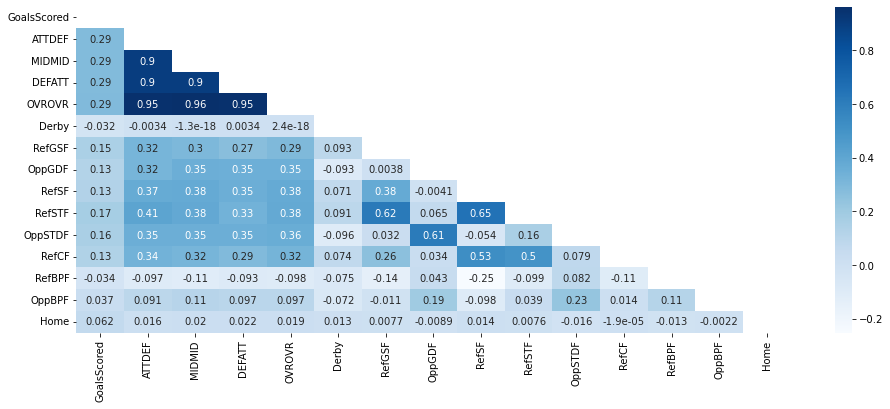

In [6]:
## Analysis of Variable Relationships

corr = data_train.drop(columns = ['Index']).corr()

# Getting the Upper Triangle of the Correlation Matrix
matrix = np.triu(corr)

# Plotting a Correlation Heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(corr, annot=True, mask=matrix, annot_kws={"size": 10}, cmap="Blues")

<font face="Times New Roman"><h2>5. The Poisson Linear Model</h2></font>
<font face="Times New Roman"><h3>5.1 Model Build</h3></font>

In [7]:
## Regression Input and Output Variables
Y = data_train['GoalsScored']
X = data_train[['Home', 'Derby', 'OVROVR', 'RefSTF', 'OppSTDF']]
X = sm.add_constant(X)
X = np.array(X)

# Normalisation
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X))
X_train = normalizer(X)

### Modelling

## Neural Network Model
def model_builder(hp):
  
  model = keras.Sequential()
  
  # Number of Hidden Layers
  hp_hidden_layers = hp.Int('hidden_layers', min_value = 0, max_value = 2, step = 1)
  for i in range(hp_hidden_layers + 1):
      # No Hidden Layers
      if i == 0:
          # Input Layer
          model.add(keras.layers.InputLayer(input_shape = (6,)))
          
          # Output Layer
          model.add(keras.layers.Dense(1))
      
      # NN with 1 Hidden Layer, Dropout and L2 Regularisation    
      elif i == 1:
          # 1st Hidden Layer
          hp_nodes1 = hp.Int('units1', min_value = 2, max_value = 5, step = 1)
          hp_lambda1 = hp.Choice('lambda1', 
                                 values = [0.0, 0.001, 0.0025, 0.005, 0.01])
          hp_dropout1 = hp.Choice('dropout1', values = [0.0, 0.3, 0.4])
          model.add(keras.layers.Dense(units = hp_nodes1, activation = 'relu', 
                                       input_shape = (6,),
                                       kernel_regularizer = keras.regularizers.l1_l2(l2 = hp_lambda1)))
          model.add(keras.layers.Dropout(hp_dropout1))
          
          # Output Layer          
          model.add(keras.layers.Dense(1))
      
      # 2 Hidden Layers, Dropout and L2 Regularisation    
      elif i == 2:
          # 1st Hidden Layer
          hp_nodes1 = hp.Int('units1', min_value = 2, max_value = 5, step = 1)
          hp_lambda1 = hp.Choice('lambda1', 
                                 values = [0.0, 0.001, 0.0025, 0.005, 0.01])
          hp_dropout1 = hp.Choice('dropout1', values = [0.0, 0.3, 0.4])
          model.add(keras.layers.Dense(units = hp_nodes1, activation = 'relu', 
                                       input_shape = (6,),
                                       kernel_regularizer = keras.regularizers.l1_l2(l2 = hp_lambda1)))
          model.add(keras.layers.Dropout(hp_dropout1))
          
          # 2nd Hidden Layer
          hp_nodes2 = hp.Int('units2', min_value = 2, max_value = 4, step = 1)
          hp_lambda2 = hp.Choice('lambda2', 
                                 values = [0.0, 0.001, 0.0025, 0.005, 0.01])
          hp_dropout2 = hp.Choice('dropout2', values = [0.0, 0.3, 0.4])
          model.add(keras.layers.Dense(units = hp_nodes2, activation = 'relu', 
                                       input_shape = (6,),
                                       kernel_regularizer = keras.regularizers.l1_l2(l2 = hp_lambda2)))
          model.add(keras.layers.Dropout(hp_dropout2))
                    
          # Output Layer
          model.add(keras.layers.Dense(1))
          
  
  # Learning Rate
  hp_learning_rate = hp.Choice('learning_rate', values = [0.001, 0.002, 0.005, 0.01])
  
  # Compile the Model
  model.compile(optimizer=keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss='mean_absolute_error', metrics = ['accuracy'])
  return model

<font face="Times New Roman"><h3>5.2 Hyper parameter tuning and Model Training</h3></font>
<p>&#10071;&#9203; The following code block takes a little more than 7 minutes to run</p>

In [8]:
## Hyperparameter Tuning
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss',
                     #max_epochs = 50,
                     directory = path,
                     project_name = 'project')

# Early Stopping Regularisation
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20)

# Hyperparameter Tuning Search with 80-20 Training-Validation Split
tuner.search(X_train, Y, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the Optimal Hyperparameters
tuner.results_summary()
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# Build the Model with the Optimal Hyperparameters
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the Model
history = hypermodel.fit(X_train, Y, epochs=200, validation_split=0.2, callbacks=[stop_early])

Trial 254 Complete [00h 00m 10s]
val_loss: 0.9333817362785339

Best val_loss So Far: 0.8894444704055786
Total elapsed time: 00h 07m 21s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:/Users/DELL/OneDrive/Documents/project/Updated Code and Datasets/project
Showing 10 best trials
Trial summary
Hyperparameters:
hidden_layers: 1
learning_rate: 0.01
units1: 5
lambda1: 0.001
dropout1: 0.3
units2: 2
lambda2: 0.001
dropout2: 0.0
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0190
Score: 0.8894444704055786
Trial summary
Hyperparameters:
hidden_layers: 1
learning_rate: 0.005
units1: 4
lambda1: 0.01
dropout1: 0.0
units2: 4
lambda2: 0.0025
dropout2: 0.0
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0228
Score: 0.8908488154411316
Trial summary
Hyperparameters:
hidden_layers: 1
learning_rate: 0.01
units1: 4
lambda1: 0.0
dropout1: 0.3
units2: 4
lambda2: 0.001
dropout2: 0.3
tuner/epochs: 100
tuner

65/65 [==============================] - 0s 2ms/step - loss: 0.9414 - accuracy: 0.3236 - val_loss: 0.8969 - val_accuracy: 0.3210
Epoch 39/200
65/65 [==============================] - 0s 2ms/step - loss: 0.9370 - accuracy: 0.3304 - val_loss: 0.8901 - val_accuracy: 0.2840
Epoch 40/200
65/65 [==============================] - 0s 2ms/step - loss: 0.9417 - accuracy: 0.3241 - val_loss: 0.8926 - val_accuracy: 0.3171
Epoch 41/200
65/65 [==============================] - 0s 2ms/step - loss: 0.9376 - accuracy: 0.3304 - val_loss: 0.8938 - val_accuracy: 0.3191
Epoch 42/200
65/65 [==============================] - 0s 2ms/step - loss: 0.9379 - accuracy: 0.3275 - val_loss: 0.8926 - val_accuracy: 0.3054
Epoch 43/200
65/65 [==============================] - 0s 2ms/step - loss: 0.9390 - accuracy: 0.3255 - val_loss: 0.9065 - val_accuracy: 0.3307
Epoch 44/200
65/65 [==============================] - 0s 2ms/step - loss: 0.9414 - accuracy: 0.3260 - val_loss: 0.8973 - val_accuracy: 0.3210
Epoch 45/200
65/65 

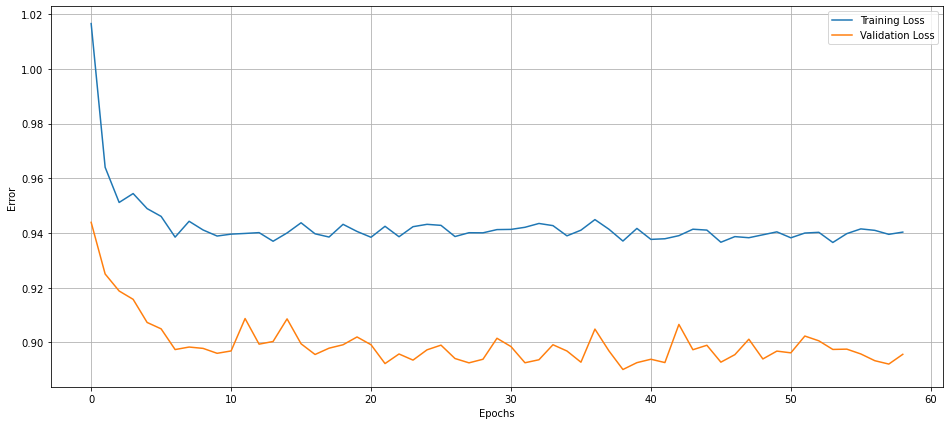

In [9]:
## Learning Curve Plot
plt.figure(figsize=(16, 7))
def plot_loss(history):
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
  
plot_loss(history)

<font face="Times New Roman"><h3>5.3 Test Data Model Fit</h3></font>

In [10]:
## Test Set Evaluation
Y_test = data_test['GoalsScored']
X_test = data_test[['Home', 'Derby', 'OVROVR', 'RefSTF', 'OppSTDF']]
X_test = sm.add_constant(X_test)
X_test = normalizer(X_test)

eval_result = hypermodel.evaluate(X_test, Y_test)

## Fit Model on Test Data
data = df.dropna(subset=['RefGSF'])
data_test = data[data['Season'] == 20212022]
data_test['Lambda'] = np.exp(hypermodel.predict(X_test))

20/20 [==============================] - 0s 856us/step


C:\Users\DELL\AppData\Local\Temp\ipykernel_14904\1475486168.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['Lambda'] = np.exp(hypermodel.predict(X_test))


<font face="Times New Roman"><h3>5.4 Final Match Results Simulation</h3></font>

In [11]:
## Scoreline Simulation (Final Match Results)
sim = []
for i in range(len(data_test.index)):
    val = list(np.random.poisson(data_test.iloc[i]['Lambda'], 10000))
    sim.append(val)

sim_df = pd.DataFrame(sim)

sim_df['Index'] = list(data_test['Index'])
sim_df['Home'] = list(data_test['Home'])

index_set = list(set(sim_df['Index']))
sim_prob = []
for i in index_set:
    df_temp = sim_df[sim_df['Index'] == i]
    
    home = df_temp[df_temp['Home'] == 1]
    home = home.drop(columns = ['Index','Home'])
    away = df_temp[df_temp['Home'] == 0]
    away = away.drop(columns = ['Index','Home'])
    
    goal_diff = np.array(home) - np.array(away)
    home_win = len(goal_diff[goal_diff > 0])/10000
    draw = len(goal_diff[goal_diff == 0])/10000
    home_loss = len(goal_diff[goal_diff < 0])/10000
    prob = [home_win, draw, home_loss]
    sim_prob.append(prob)
    
sim_prob_df = pd.DataFrame(sim_prob, 
                           columns = ['HomeWin', 'Draw', 'HomeLoss'])
sim_prob_df['Index'] = index_set 

<font face="Times New Roman"><h2>6. Results</h2></font>
<font face="Times New Roman"><h3>6.1 Obtaining Betting probabilities from Betting Odds</h3></font>

In [12]:
## Model Probabilties vs Bet365 Probabilities
            
# Model Probabilties
df_betting = pd.read_csv(path + 'betting_data.csv')            
data_betting = df_betting[df_betting['Season'] == 20212022]
data_betting = pd.merge(data_betting, sim_prob_df, on = 'Index')

# Bet365 Probabilities from Betting Odds
bookies_prob = []
for i in range(len(data_betting)):
    # Calculating the Booksum
    Sum = 1/data_betting['B365H'][i] + 1/data_betting['B365D'][i] + 1/data_betting['B365A'][i]
    # Calculation of Home Win, Draw, and Loss Probabilities
    Bet365HomeWin = (1/data_betting['B365H'][i])/Sum
    Bet365Draw = (1/data_betting['B365D'][i])/Sum
    Bet365AwayWin = (1/data_betting['B365A'][i])/Sum
    IN = data_betting['Index'][i]
    prob = [Bet365HomeWin, Bet365Draw, Bet365AwayWin, IN]
    bookies_prob.append(prob) 

# storing the betting probabilities as a dataframe    
bookies_prob_df = pd.DataFrame(bookies_prob, columns = ['BookiesWin', 'BookiesDraw', 'BookiesLoss', 'Index'])
 
# Combining Model and Bet365 Probabilities into Single Dataset        
data_betting = pd.merge(data_betting, bookies_prob_df, on = 'Index')

<font face="Times New Roman"><h3>6.2 Plot of Model Probabilities vs Bet365 Probabilities</h3></font>

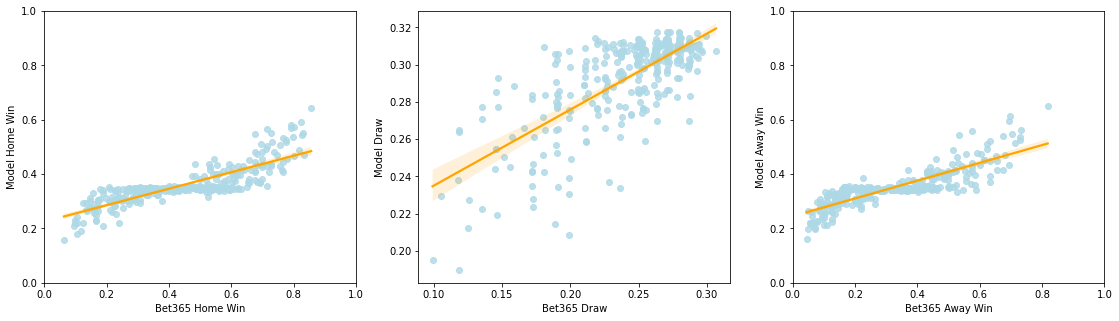

In [13]:
## Plot of Model Probabilities vs Bet365 Probabilities
plt.figure(figsize=(19, 5))

# Plot of Home Win Probabilities
plt.subplot(1, 3, 1)
sns.regplot(x = "BookiesWin", y = "HomeWin", data = data_betting, 
            scatter_kws = {"color": "lightblue"}, 
            line_kws = {"color": "orange"})
plt.xlabel('Bet365 Home Win')
plt.ylabel('Model Home Win')
plt.xlim(0, 1)
plt.ylim(0, 1)

# Plot of Draw Probabilities
plt.subplot(1, 3, 2)
sns.regplot(x = "BookiesDraw", y = "Draw", data = data_betting, 
            scatter_kws = {"color": "lightblue"}, 
            line_kws = {"color": "orange"})
plt.xlabel('Bet365 Draw')
plt.ylabel('Model Draw')
#plt.xlim(0, 0.5)
#plt.ylim(0, 0.3)

# Plot of Away Win Probabilities
plt.subplot(1, 3, 3)
sns.regplot(x = "BookiesLoss", y = "HomeLoss", data = data_betting, 
            scatter_kws = {"color": "lightblue"}, 
            line_kws = {"color": "orange"})
plt.xlabel('Bet365 Away Win')
plt.ylabel('Model Away Win')
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show() 

<font face="Times New Roman"><h3>6.3 Ranked probability scores</h3>
The Ranked Probability Score (RPS) is a measure of how good forecasts are in matching observed outcomes. Where: RPS = 0 the forecast is wholly accurate; RPS = 1 the forecast is wholly inaccurate.
</font>

In [14]:
## Ranked Probability Score (RPS)
RPS_model = []
RPS_bookies = []

# RPS Function
def rps(predictions, observed):

    assert (
        predictions.shape == observed.shape
    ), "prediction and observed array shapes must match"
    ncat = predictions.shape[1] - 1
    return (
        np.sum(
            (np.cumsum(predictions, axis=1) - np.cumsum(observed, axis=1)) ** 2, axis=1
        ) / ncat
    )

# RPS Comaprison
predictions_model = data_betting[['HomeWin', 'Draw', 'HomeLoss']]
predictions_model.columns = ['H', 'D', 'A']
predictions_bookies = data_betting[['BookiesWin', 'BookiesDraw', 'BookiesLoss']]
predictions_bookies.columns = ['H', 'D', 'A']
observed = pd.get_dummies(data_betting['FTR']).reindex(
    columns=predictions_model.columns, fill_value=0)
  
RPS_model = rps(predictions_model, observed).round(5)
RPS_bookies= rps(predictions_bookies, observed).round(5)

# Display of RPS score and their Difference
print("Ranked Probability Score of our model",round(np.mean(RPS_model),4))
print("Ranked Probability Score of Bookies model",round(np.mean(RPS_bookies),4))
print("Ranked Probability Score difference",round((np.mean(RPS_model) - np.mean(RPS_bookies)),4))

Ranked Probability Score of our model 0.2139
Ranked Probability Score of Bookies model 0.1992
Ranked Probability Score difference 0.0148


<font face="Times New Roman"><h3>6.4 Confusion Matrix</h3>
A confusion matrix is a table that is used to define the performance of a classification algorithm. A confusion matrix visualizes and summarizes the performance of a classification algorithm.
</font>

<AxesSubplot:title={'center':'True Vs Bookies Model'}>

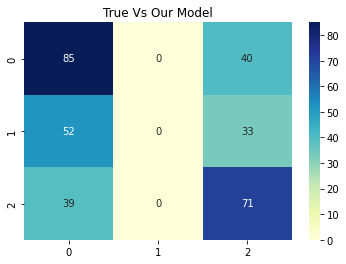

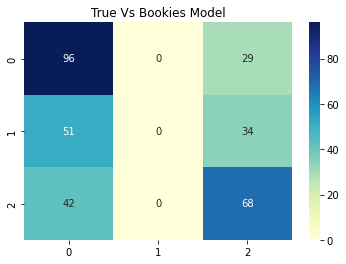

In [15]:
## Confusion Matrix
y_model = np.argmax(np.array(predictions_model), axis = 1)
y_bookies = np.argmax(np.array(predictions_bookies), axis = 1)
y_true = np.argmax(np.array(observed), axis = 1)

# Obtaining the Confusion Matrix
cm1 = confusion_matrix(y_true, y_model)
cm2 = confusion_matrix(y_true, y_bookies)
plt.figure()
plt.title('True Vs Our Model')
sns.heatmap(cm1, annot=True, cmap='YlGnBu')
plt.figure()
plt.title('True Vs Bookies Model')
sns.heatmap(cm2, annot=True, cmap='YlGnBu')

<font face="Times New Roman"><h3>6.5 Precision, Recall and F1-Score Table</h3>
Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.<br>
F1-score is the harmonic mean of precision and recall. It combines precision and recall into a single number using the following formula: This formula can also be equivalently written as, Notice that F1-score takes both precision and recall into account, which also means it accounts for both False Positives and False Negatives.
</font>

In [16]:
# Precision, Recall and F1-score for Model and Bet365
from sklearn import metrics
print('\033[1m'+'True Vs Our Model\n'+'\033[0m')
print(metrics.classification_report(y_true, y_model, target_names = ['H','D','A']))
print('\033[1m'+'True Vs Bookies Model\n'+'\033[0m')
print(metrics.classification_report(y_true, y_bookies, target_names = ['H','D','A']))

True Vs Our Model

              precision    recall  f1-score   support

           H       0.48      0.68      0.56       125
           D       0.00      0.00      0.00        85
           A       0.49      0.65      0.56       110

    accuracy                           0.49       320
   macro avg       0.33      0.44      0.37       320
weighted avg       0.36      0.49      0.41       320

True Vs Bookies Model

              precision    recall  f1-score   support

           H       0.51      0.77      0.61       125
           D       0.00      0.00      0.00        85
           A       0.52      0.62      0.56       110

    accuracy                           0.51       320
   macro avg       0.34      0.46      0.39       320
weighted avg       0.38      0.51      0.43       320



C:\Users\DELL\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\anaconda3\envs\tf\li